# Cryptanalysis of an SPN Toy Cipher Using Feedforward Neural Networks

This notebook is a small wrap-up of experimental tests made during my master's thesis [Wab19], and contains the code and used hyperparameters for the experimental results presented in it. It demonstrates the attacks on block ciphers, presented in [AW04] and [Wab19], by using the SPN toy cipher of Heys' tutorial on linear and differential cryptanalysis [Hey02].

In this demonstration, the SPN cipher is attacked by trying to revover the leftmost four bits of the last round key. For further information, see [Wab19].

## Required Imports

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from numpy import array
from keras import backend as K
from keras.models import Sequential 
from keras.layers import Dense
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


## Helper Methods

In [2]:
def int_to_bin(integer, digits):
    """
    Converts the passed integer to binary representation and returns it in form of a list of length `digits`.
    """
    form = '{0:0' + str(digits) + 'b}'
    return [int(b) for b in form.format(integer)]
    
def bin_to_int(binary):
    """
    Returns the integer which the passed binary list represents.
    """
    return int(''.join(str(i) for i in binary), 2)

def get_random_bit_lists(n, bits):
    """
    Generates `n` distinct bit lists of length `bits`. 
    """
    different_random_values = np.random.choice(range(2**bits), n, replace=False)
    lists = [list(array(list(np.binary_repr(value, width=bits))).astype(np.int)) for value in different_random_values]
    return lists

## SPN Toy Cipher

In [3]:
class BasicSPNCipher:
    
    sbox = [14, 4, 13, 1, 2, 15, 11, 8, 3, 10, 6, 12, 5, 9, 0, 7]
    sbox_rev = [14, 3, 4, 8, 1, 12, 10, 15, 7, 13, 9, 6, 11, 2, 0, 5]
    
    def __init__(self, keys=None):
        self._keys = keys
        
    @staticmethod
    def __perm(t):
        return [t[0], t[4], t[8], t[12], t[1], t[5], t[9], t[13], t[2], t[6], t[10], t[14], t[3], t[7], t[11], t[15]]
            
    
    @staticmethod
    def __subst(t, reverse=False):
        if reverse == False:
            return int_to_bin(BasicSPNCipher.sbox[bin_to_int(t)], 4)
        else:
            return int_to_bin(BasicSPNCipher.sbox_rev[bin_to_int(t)], 4)
        
    @staticmethod
    def __mix_key(t, k):
        return [t[i] ^ k[i] for i in range(len(t))]
    
    @staticmethod
    def __subst_step(t, reverse=False):
        output = []
        inputs = [t[i:i+4] for i in range(0, 16, 4)]
        for inp in inputs:
            output += BasicSPNCipher.__subst(inp, reverse)
        return output
        
    def encrypt(self, p, rounds=4):      
        for i in range(3):
            p = BasicSPNCipher.__mix_key(p, self._keys[i])
            p = BasicSPNCipher.__subst_step(p)
            p = BasicSPNCipher.__perm(p)
        p = BasicSPNCipher.__mix_key(p, self._keys[3])
        if rounds == 3:
            return p
        p = BasicSPNCipher.__subst_step(p)
        return BasicSPNCipher.__mix_key(p, self._keys[4])
    
    def decrypt(self, c):
        c = BasicSPNCipher.__mix_key(c, self._keys[4])
        c = BasicSPNCipher.__subst_step(c, reverse=True)
        c = BasicSPNCipher.__mix_key(c, self._keys[3])
        for i in [2, 1, 0]:
            c = BasicSPNCipher.__perm(c)
            c = BasicSPNCipher.__subst_step(c, reverse=True)
            c = BasicSPNCipher.__mix_key(c, self._keys[i])
        return c
    
    def partial_decrypt(self, c, key):
        c = BasicSPNCipher.__mix_key(c, key)
        return BasicSPNCipher.__subst_step(c, reverse=True)

## Model and Training Hyperparameters
This model and hyperparameters are used for attacking the cipher with the subsequent methods. Note that due to the cipher and implementation, the input layer should have 16 and the output layer 4 units.

In [4]:
EPOCHS = 200
BATCH_SIZE = 128

def get_model():
    model = Sequential()
    model.add(Dense(256, input_dim=16, activation='relu'))
    model.add(Dense(4, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['mse'])
    return model

## Attack One
This is the attack presented by Albassal and Wahdan in [AW04]. Feel free to adjust the number of known plaintext-ciphertext pairs and number of tests. Each test tries to recover the leftmost four bits of the last round key. How many of the known pairs are used for training the neural network is also adjustable.

In [5]:
NUM_OF_PAIRS = 6000
NUM_OF_TESTS = 10
# Fraction to use for the training set. The rest is used for evaluating the network.
FRACTION = 0.7

top_1 = 0
top_3 = 0
for t in range(NUM_OF_TESTS):
    key = get_random_bit_lists(5, 16)
    correct_partial_subkey = key[4][:4]
    cipher = BasicSPNCipher(key)
    plaintexts = get_random_bit_lists(NUM_OF_PAIRS, 16)
    ciphertexts = [cipher.encrypt(p) for p in plaintexts]

    training_ex_num = int(FRACTION * NUM_OF_PAIRS)
    p_training = plaintexts[:training_ex_num]
    p_test = plaintexts[training_ex_num:]

    results = []
    for k in range(16):
        partial_subkey = int_to_bin(k, 4)
        subkey = partial_subkey + 12*[0]
        c_tilde = [cipher.partial_decrypt(c, subkey)[:4] for c in ciphertexts]
        c_tilde_training = c_tilde[:training_ex_num]
        c_tilde_test = c_tilde[training_ex_num:]
        model = get_model()
        model.fit(array(p_training), array(c_tilde_training),
                  epochs=EPOCHS, batch_size=BATCH_SIZE,
                  verbose=0)
        results.append(model.evaluate(array(p_test), array(c_tilde_test), verbose=0)[1])
        K.clear_session()

    results = array(results)
    correct_key = bin_to_int(correct_partial_subkey)
    if correct_key in results.argsort()[:3]:
        top_3 += 1
        if correct_key in results.argsort()[:1]:
            top_1 += 1
    
print("Recovered the correct key:                  " + str(top_1) + "/" + str(NUM_OF_TESTS)) 
print("Correct key was among the top 3 candidates: " + str(top_3) + "/" + str(NUM_OF_TESTS))

Recovered the correct key:                  7/10
Correct key was among the top 3 candidates: 10/10


## Attack Two
This is Method 1 of [Wab19], which is basically the attack by Albassal and Wahdan, but without splitting the set of plaintext-ciphertext pairs.

In [6]:
NUM_OF_PAIRS = 6000
NUM_OF_TESTS = 10

top_1 = 0
top_3 = 0
for t in range(NUM_OF_TESTS):
    key = get_random_bit_lists(5, 16)
    correct_partial_subkey = key[4][:4]
    cipher = BasicSPNCipher(key)
    plaintexts = get_random_bit_lists(NUM_OF_PAIRS, 16)
    ciphertexts = [cipher.encrypt(p) for p in plaintexts]

    results = []
    for k in range(16):
        partial_subkey = int_to_bin(k, 4)
        subkey = partial_subkey + 12*[0]
        c_tilde = [cipher.partial_decrypt(c, subkey)[:4] for c in ciphertexts]
        model = get_model()
        model.fit(array(plaintexts), array(c_tilde),
                  epochs=EPOCHS, batch_size=BATCH_SIZE,
                  verbose=0)
        results.append(model.evaluate(array(plaintexts), array(c_tilde), verbose=0)[1])
        K.clear_session()
    results = array(results)

    correct_key = bin_to_int(correct_partial_subkey)
    if correct_key in results.argsort()[:3]:
        top_3 += 1
        if correct_key in results.argsort()[:1]:
            top_1 += 1

print("Recovered the correct key:                  " + str(top_1) + "/" + str(NUM_OF_TESTS)) 
print("Correct key was among the top 3 candidates: " + str(top_3) + "/" + str(NUM_OF_TESTS))

Recovered the correct key:                  9/10
Correct key was among the top 3 candidates: 9/10


## Attack Three
These are different versions of Method 2 of [Wab19], which are outlined in Section 4.4.1.

In [7]:
NUM_OF_PAIRS = 6000
NUM_OF_TESTS = 10
# Number of NNs used for retrieving reference values.
NUM_OF_NN_REF = 16
# Number of NNs  used for each possible partial last round key.
NUM_OF_NN = 1

average_mse_top_1 = 0
average_mse_top_3 = 0

norm_sum_top_1 = 0
norm_sum_top_3 = 0

norm_feature_scaling_top_1 = 0
norm_feature_scaling_top_3 = 0

mses_top_1 = 0
mses_top_3 = 0

for t in range(NUM_OF_TESTS):
    key = get_random_bit_lists(5, 16)
    correct_partial_subkey = key[4][:4]
    cipher = BasicSPNCipher(key)
    plaintexts = get_random_bit_lists(NUM_OF_PAIRS, 16)
    ciphertexts = [cipher.encrypt(p) for p in plaintexts]
    
    ref_average_mse = []
    ref_mses = []
    for i in range(NUM_OF_NN_REF):
        training_key = get_random_bit_lists(5, 16)
        training_cipher = BasicSPNCipher(training_key)
        ref_ciphertexts = array([training_cipher.encrypt(p, rounds=3)[:4] for p in plaintexts])
        plaintexts = array(plaintexts)
        train_model = get_model()
        train_model.fit(plaintexts, ref_ciphertexts,
                        epochs=EPOCHS, batch_size=BATCH_SIZE,
                        verbose=0)
        ref_preds = train_model.predict(plaintexts)
        ref_mses_i = mean_squared_error(ref_ciphertexts, ref_preds, multioutput='raw_values')
        ref_mses.append(ref_mses_i)
        ref_average_mse.append(np.average(ref_mses_i))
        K.clear_session()
    ref_mses = np.average(ref_mses, axis=0)
    ref_average_mse = np.average(ref_average_mse)
          
    all_average_mse = []
    all_mses = []
    for k in range(16):
        partial_subkey = int_to_bin(k, 4)
        subkey = partial_subkey + 12*[0]
        c_tilde = array([cipher.partial_decrypt(c, subkey)[:4] for c in ciphertexts])
        mses = []
        average_mse = []
        for i in range(NUM_OF_NN):
            model= get_model()
            model.fit(plaintexts, c_tilde,
                      epochs=EPOCHS, batch_size=BATCH_SIZE,
                      verbose=0)
            preds = model.predict(plaintexts)
            mses_i = mean_squared_error(c_tilde, preds, multioutput='raw_values')
            mses.append(mses_i)
            average_mse.append(np.average(mses_i))
            K.clear_session()
        all_mses.append(np.average(array(mses), axis=0).tolist())
        all_average_mse.append(np.average(array(average_mse)))

    m2_differences = []
    m2_average_differences = []
    norm_feature_scaling_differences = []
    norm_sum_differences = []

    for mses in all_mses:
        m2_differences.append(np.sum(np.square(mses - ref_mses)))
        
    for average_mse in all_average_mse:
        m2_average_differences.append(np.sum(np.abs(average_mse - ref_average_mse)))
        
    for mses in all_mses:
        norm_mses = mses / np.sum(mses)
        norm_ref_mses = ref_mses / np.sum(ref_mses)
        norm_sum_differences.append(np.sum(np.square(norm_mses - norm_ref_mses)))
        
    for mses in all_mses:
        scaler = MinMaxScaler()
        mses = np.array(mses).reshape(-1,1)
        scaler.fit(mses)
        mses = scaler.transform(mses)
        ref_mses = ref_mses.reshape(-1,1)
        scaler.fit(ref_mses)
        ref_mses = scaler.transform(ref_mses)
        norm_feature_scaling_differences.append(np.sum(np.square(mses - ref_mses)))
    
    m2_differences = array(m2_differences)
    m2_average_differences = array(m2_average_differences)
    norm_feature_scaling_differences = array(norm_feature_scaling_differences)
    norm_sum_differences = array(norm_sum_differences)

    correct_key = bin_to_int(correct_partial_subkey)
            
    if correct_key in m2_differences.argsort()[:3]:
        mses_top_3 += 1
        if correct_key in m2_differences.argsort()[:1]:
            mses_top_1 += 1
            
    if correct_key in m2_average_differences.argsort()[:3]:
        average_mse_top_3 += 1
        if correct_key in m2_average_differences.argsort()[:1]:
            average_mse_top_1 += 1
            
    if correct_key in norm_sum_differences.argsort()[:3]:
        norm_sum_top_3 += 1
        if correct_key in norm_sum_differences.argsort()[:1]:
            norm_sum_top_1 += 1
            
    if correct_key in norm_feature_scaling_differences.argsort()[:3]:
        norm_feature_scaling_top_3 += 1
        if correct_key in norm_feature_scaling_differences.argsort()[:1]:
            norm_feature_scaling_top_1 += 1
            
print("Method 2")
print("Recovered the correct key:                  " + str(mses_top_1) + "/" + str(NUM_OF_TESTS)) 
print("Correct key was among the top 3 candidates: " + str(mses_top_3) + "/" + str(NUM_OF_TESTS))
print()

print("Method 2 (Average)")
print("Recovered the correct key:                  " + str(average_mse_top_1) + "/" + str(NUM_OF_TESTS)) 
print("Correct key was among the top 3 candidates: " + str(average_mse_top_3) + "/" + str(NUM_OF_TESTS))
print()

print("Normalization (Feature Scaling)")
print("Recovered the correct key:                  " + str(norm_feature_scaling_top_1) + "/" + str(NUM_OF_TESTS)) 
print("Correct key was among the top 3 candidates: " + str(norm_feature_scaling_top_3) + "/" + str(NUM_OF_TESTS))
print()

print("Normalization (Same Average)")
print("Recovered the correct key:                  " + str(norm_sum_top_1) + "/" + str(NUM_OF_TESTS)) 
print("Correct key was among the top 3 candidates: " + str(norm_sum_top_3) + "/" + str(NUM_OF_TESTS))

Method 2
Recovered the correct key:                  5/10
Correct key was among the top 3 candidates: 9/10

Method 2 (Average)
Recovered the correct key:                  6/10
Correct key was among the top 3 candidates: 9/10

Normalization (Feature Scaling)
Recovered the correct key:                  0/10
Correct key was among the top 3 candidates: 4/10

Normalization (Same Average)
Recovered the correct key:                  2/10
Correct key was among the top 3 candidates: 5/10


See [Wab19, p. 51] for more reliable results.

## Position-Specific Performances
The results above indicate that the performances for the individual bit positions differ. This is visualized for the encryption function of the reduced cipher (3 rounds):

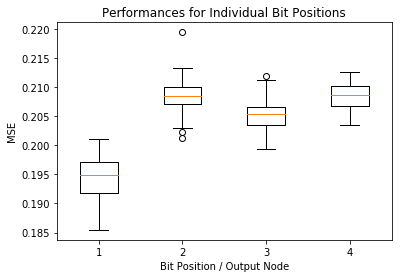

In [8]:
NUM_OF_TESTS = 50
NUM_OF_PLAINTEXTS = 8000

positions = [[], [], [], []]
for t in range(NUM_OF_TESTS):
    key = get_random_bit_lists(5, 16)
    cipher = BasicSPNCipher(key)
    plaintexts = get_random_bit_lists(NUM_OF_PLAINTEXTS, 16)
    ciphertexts = [cipher.encrypt(p, rounds=3)[:4] for p in plaintexts]
    plaintexts = array(plaintexts)
    ciphertexts = array(ciphertexts)
    
    model = get_model()
    model.fit(plaintexts, ciphertexts,
              epochs=EPOCHS, batch_size=BATCH_SIZE,
              verbose=0)

    preds = model.predict(plaintexts)
    mses = mean_squared_error(ciphertexts, preds, multioutput='raw_values')
    for i in range(4):
        positions[i].append(mses[i])     
    K.clear_session()
    
plt.boxplot([positions[0], positions[1], positions[2], positions[3]])
plt.title('Performances for Individual Bit Positions')
plt.xlabel('Bit Position / Output Node')
plt.ylabel('MSE')
plt.show()

## References
[AW04]
A. M. B. Albassal and A.-M. A. Wahdan. Neural network based cryptanalysis of a Feistel type block cipher. In                 *International Conference on Electrical, Electronic and Computer Engineering, 2004. ICEEC '04*, pages 231–237, 2004.

[Hey02]
H. M. Heys. A tutorial on linear and differential cryptanalysis. *Cryptologia*, 26(3):189–221, 2002.

[Wab19]
J. Wabbersen. Cryptanalysis of Block Ciphers Using Feedforward Neural Networks. [http://www.stud.informatik.uni-goettingen.de/~jan.wabbersen/Cryptanalysis_of_Block_Ciphers_Using_Feedforward_Neural_Networks.pdf](http://www.stud.informatik.uni-goettingen.de/~jan.wabbersen/Cryptanalysis_of_Block_Ciphers_Using_Feedforward_Neural_Networks.pdf), 2019.